# Description

**Author:** Anna Luisa Hemshorn de Sánchez

**Affiliation:** (1) Department of Earth Sciences, VU Amsterdam, (2) Institute of Environmental Studies (IVM), VU Amsterdam, (3) Deltares

**Contact:** a.l.hemshorndesanchez@vu.nl

**Version:** V1

**Date:** Oct 20, 2025

**Description:** Data used in this notebook is obtained from: do Nascimento, T.V.M., Rudlang, J., Höge, M. et al. EStreams: An integrated dataset and catalogue of streamflow, hydro-climatic and landscape variables for Europe. _Sci Data_ 11, 879 (2024). https://doi.org/10.1038/s41597-024-03706-1

In this code we compute climate sensitivities of streamflow metrics at seasonal timescale:

* seasonal mean precipitation elasticities of annual mean, max and min streamflow
* seasonal max precipitation elasticities of annual max streamflow
* seasonal mean temperature sensitivities of annual mean, max and min streamflow

We use the precipitation and Temperature of a specific season and compare it to the flow in the entire year. The seasons  are defined as:
* Cold season hfs=Nov-Apr and 
* Warm season lfs = May-Oct

# Import packages

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.wkt import loads
from functools import reduce
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.stats import spearmanr, gaussian_kde,linregress, theilslopes, pearsonr, t, skew, sem
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, LinearSegmentedColormap, to_rgb, ListedColormap
from matplotlib.offsetbox import AnchoredText
from matplotlib.transforms import Affine2D
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D
from cmcrameri import cm # to be cited
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor #, HuberRegressor
from sklearn.utils import resample
from sklearn.metrics import r2_score
import statsmodels.api as sm
import colorcet as cc
import sys
import gc

# Define file paths

In [2]:
# Get main directories
nb_dir = Path.cwd()
parent_dir = nb_dir.parent.parent.parent.parent
fp = parent_dir / "Data/Europe/estreams/EStreams_v1.3/"

# Input directories and filepaths
fp_gauges = fp / "streamflow_gauges/estreams_gauging_stations.csv"
fp_met = fp / "meteorology/" # contains: estreams_meteorology_{basin_id}.csv
fp_hydsig = fp / "hydroclimatic_signatures/estreams_hydrometeo_signatures.csv"
fp_shp_gau = fp / "shapefiles/estreams_gauging_stations.shp"
fp_shp_cat = fp / "shapefiles/estreams_catchments.shp"
fp_attr_stat = fp / "attributes/static_attributes/" # contains: estreams_{attribute_type}_attributes.csv
fp_attr_temp = fp / "attributes/temporal_attributes/" # contains: estreams_{attribute_type}_[time_scale].csv
fp_qidx_mon = fp / "streamflow_indices/monthly/" # contains: monthly_streamflow_{index}.csv
fp_qidx_season = fp / "streamflow_indices/seasonal/" # contains: seasonal_streamflow_{index}.csv
fp_qidx_week = fp / "streamflow_indices/weekly/" # contains: weekly_streamflow_{index}.csv
fp_qidx_year = fp / "streamflow_indices/yearly/" # contains: yearly_streamflow_{index}.csv

# Output directories
fp_gh = parent_dir / "Code/GitHub/streamflow_sensitivity_europe/"
fp_processed = fp_gh / "data/processed/" 
fp_tempstats = fp_processed / "02_temporal_stats/" 
fp_out_hyr = fp_tempstats / "02_hyearly/"
fp_out_ssn = fp_tempstats / "03_seasonal/"
fp_figures = fp_gh / "figures/"

# Read data

In [3]:
basin_id_sel = pd.read_csv(fp_processed/"01_selection/basin_id_sel.csv", index_col=0)['basin_id']
print('Amount of gauges: ', len(basin_id_sel))

# Load the Europe boundaries (Natural Earth dataset)
europe = gpd.read_file(parent_dir/"Data/Admin/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp") #CNTR_BN_01M_2020_3035.shp/CNTR_BN_01M_2020_3035.shp')#
europe = europe[(europe['CONTINENT'].str.contains('Europe', case=False, na=False)) |
                ((europe.geometry.bounds['minx'] >= -10) &     
                 (europe.geometry.bounds['maxx'] <= 50) &
                 (europe.geometry.bounds['miny'] >= 30) & 
                 (europe.geometry.bounds['maxy'] <= 70))] #europe = europe.cx[-10:50, 30:70] #europe = europe[europe['CONTINENT'] == 'Europe']

# Overview DataFrame that is used to store all new results into
result_df = pd.read_csv(fp_processed/f"01_selection/gauges_metadata.csv", index_col='basin_id')
result_df['geometry'] = result_df['wkt_geometry'].apply(loads)
result_gdf = gpd.GeoDataFrame(result_df, geometry='geometry')
result_gdf.set_crs("EPSG:4326", inplace=True)
result_gdf = result_gdf.sort_index()

Amount of gauges:  8307


In [4]:
# Define the annual split for the entire script:
MON_str = 'OCT' #'SEP'

In [5]:
# Read absolute hyearly Q and T dataframes
Qmean_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Q1dmax_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Q1dmin_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Q7dmin_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin.csv", index_col=0, parse_dates=[0])[basin_id_sel]

Tmean_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean.csv", index_col=0, parse_dates=[0])[basin_id_sel]

In [6]:
## Read normalized hyearly dataframes

# Q and P ------------------------------------------------------------------------------------------------------
Qmean_hyr_norm_QmeanPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanPmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]
Pmean_hyr_norm_QmeanPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_QmeanPmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q1dmax_hyr_norm_Q1dmaxPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Pmean_hyr_norm_Q1dmaxPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q1dmaxPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q1dmax_hyr_norm_Q1dmaxPmax = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxPmax.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Pmax_hyr_norm_Q1dmaxPmax = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmax_normalized_Q1dmaxPmax.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q1dmin_hyr_norm_Q1dminPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Pmean_hyr_norm_Q1dminPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q1dminPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q7dmin_hyr_norm_Q7dminPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Pmean_hyr_norm_Q7dminPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q7dminPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

# Q and Ep ------------------------------------------------------------------------------------------------------
Qmean_hyr_norm_QmeanEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanEpmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]
Epmean_hyr_norm_QmeanEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_QmeanEpmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q1dmax_hyr_norm_Q1dmaxEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Epmean_hyr_norm_Q1dmaxEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q1dmaxEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q1dmin_hyr_norm_Q1dminEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Epmean_hyr_norm_Q1dminEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q1dminEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q7dmin_hyr_norm_Q7dminEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Epmean_hyr_norm_Q7dminEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q7dminEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

# Q and T ------------------------------------------------------------------------------------------------------
Qmean_hyr_norm_QmeanTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]
Tmean_hyr_QmeanTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_QmeanTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q1dmax_hyr_norm_Q1dmaxTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxTmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Tmean_hyr_Q1dmaxTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q1dmaxTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q1dmin_hyr_norm_Q1dminTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminTmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Tmean_hyr_Q1dminTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q1dminTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q7dmin_hyr_norm_Q7dminTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminTmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Tmean_hyr_Q7dminTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q7dminTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

# Linear Regression

How sensitive is annual mean  ($Q_{mean}$)  and extreme flow ($Q_{max}$ and $Q_{min}$) to changes in seasonal $P_{mean}$ and to changes in seasonal $T_{mean}$? Keep in mind that T is not used in its normalized form but with absolute values and the unit degC.

## Multiple linear regression

We apply search for values for $\varepsilon_P$ and $\zeta_T$ that reduce the minimum squared error:

$Q_{norm} = \alpha_0 + \varepsilon_P * P_{norm} + \zeta_T * T_{abs} + u$

Where:

* $\alpha_0$: intercept
* $\varepsilon_P$: coefficient for precipitation
* $\zeta_T$: coefficient for temperature 
* u: residual error

In [7]:
%%time
def multiple_linear_regression(Q, P, T, 
                      min_data_pts=15, ci=0.90
                     ):
    """
    Conducts multiple linear regression using annual Q timeseries and seasonal P and T 
    timeseries. It returns the streamflow elasticity and the temperature sensitivity, 
    the intercept and the p values. For all three cases it returns the R2 values.
    
    Parameters:
    - Q (pandas.DataFrame): DataFrame of the normalised annual streamflow timeseries.
    - P (pandas.DataFrame): DataFrame of the normalised seasonal precipitation timeseries.
    - T (pandas.DataFrame): DataFrame of the absolute seasonal temperature timeseries.
    - min_data_pts (int): Minimum amount of years with valid values.
    - ci (float): confidence interval.
    
    Returns:
    - output (pandas.DataFrame): DataFrame with location index, elasticity, sensitivity, intercept, p-values and R2 values.
    """
    
    output = pd.DataFrame(columns=['basin_id', 'P_elas', 'T_sens', 'intercept', 
                                   #'P_lower_ci', 'P_upper_ci',
                                   #'T_lower_ci', 'T_upper_ci', 
                                   'P_pval', 'T_pval',
                                   'r2'])
    output['basin_id'] = Q.columns

    for basin in Q.columns: # For each location (column), fit a separate linear regression: Q[:, j] ~ P[:, j] + T[:, j]
        
        mask = Q[basin].notna() & P[basin].notna() & T[basin].notna() #this ignores that one df has its datetime index in october and the other one in december
        y_Q_bsn = Q[basin][mask].values
        x_P_bsn = P[basin][mask].values
        x_T_bsn = T[basin][mask].values

        if len(y_Q_bsn) >= min_data_pts:
            x_bsn = np.column_stack((x_P_bsn, x_T_bsn))  # predictors: shape (70, 2)
            x_bsn = sm.add_constant(x_bsn)               # adds intercept term: shape (70, 3)
            y_bsn = y_Q_bsn                              # response: shape (70,)
            
            model = sm.OLS(y_bsn, x_bsn).fit(cov_type='HC3') # OLS model not robust to outliers but estimation of SEs is adjusted (HC3 is often recommended for small samples or when outliers are a concern.))
            
            output.loc[output['basin_id'] == basin, 'intercept'] = model.params[0]
            output.loc[output['basin_id'] == basin, 'P_elas'] = model.params[1]
            output.loc[output['basin_id'] == basin, 'T_sens'] = model.params[2]
            output.loc[output['basin_id'] == basin, 'r2'] = model.rsquared  
            #ci_bsn = model.conf_int(alpha=1-ci) # alpha=0.1 means 90% confidence interval
            #output.loc[output['basin_id'] == basin, ['P_lower_ci', 'P_upper_ci']] = ci_bsn[1]
            #output.loc[output['basin_id'] == basin, ['T_lower_ci', 'T_upper_ci']] = ci_bsn[2]
            output.loc[output['basin_id'] == basin, 'P_pval'] = model.pvalues[1]
            output.loc[output['basin_id'] == basin, 'T_pval'] = model.pvalues[2]
            
        else:
            output.loc[output['basin_id'] == basin, ['P_elas', 'T_sens', 'intercept', 
                                                   #'P_lower_ci', 'P_upper_ci',
                                                   #'T_lower_ci', 'T_upper_ci', 
                                                     'P_pval', 'T_pval',
                                                     'r2']] = np.nan
    output.set_index('basin_id', inplace=True)
    return output

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.91 µs


In [8]:
%%time
# multiple linear regression

mon_dict = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 
    6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 
    11: 'Nov', 12: 'Dec'
}

hfslfs_str = 'NovApr+MayOct'
hfs_season_list = [11,12,1,2,3,4]
lfs_season_list = [5,6,7,8,9,10]
season_list_dict = {'hfs': hfs_season_list, 'lfs': lfs_season_list }

ci = 0.9

def multiple_linear_regression_export(Q_str, P_str, season_type, ci=ci):
    """
    Runs multiple linear regression function and exports it to a csv file. 
    
    Parameters:
    - Q_str (str): String of the Q variable, e.g. 'Qmean'
    - P_str (str): String of the met variable, e.g. 'Pmean' or 'Pmax'
    - season_type (str): String to read in the file from the right season, e.g. 'hfs' or lfs'
    - ci (float): Confidence interval of the linear regression, e.g. 0.8
    
    Returns:
    - elas (pandas.DataFrame): Dataframe of the elasticity per basin_id
    """
    
    def read_seasonal_ts(Q_str, P_str, season_type):
        """
        Reads in the Q and the met dataframes from a particular season.

        Parameters:
        - Q_str (str): String of the Q variable, e.g. 'Qmean'.
        - met_str (str): String of the met variable, e.g. 'Pmean' or 'Pmax'.
        - season_type (str): String to read in the file from the right season, e.g. 'hfs' or lfs'.

        Returns:
        - Q_hyr_norm (pandas.DataFrame): Normalised Q 
        - P_season_norm (pandas.DataFrame)
        - T_season (pandas.DataFrame)
        """
        
        Q_hyr_norm = pd.read_csv(fp_out_ssn/f"hyr{Q_str}_for-{season_type}-{mon_dict[season_list_dict[season_type][0]]}{mon_dict[season_list_dict[season_type][-1]]}-{P_str}_normalized.csv") #This is the Q indices of the full year but norm.d for seasonal P data
        Q_hyr_norm = Q_hyr_norm.set_index('index')
        Q_hyr_norm.index.name = 'date'
        
        P_season_norm = pd.read_csv(fp_out_ssn/f"{season_type}-{mon_dict[season_list_dict[season_type][0]]}{mon_dict[season_list_dict[season_type][-1]]}-{P_str}_for-hyr{Q_str}_normalized.csv")
        P_season_norm = P_season_norm.set_index('date')
        
        T_season = pd.read_csv(fp_out_ssn/f"{season_type}-{mon_dict[season_list_dict[season_type][0]]}{mon_dict[season_list_dict[season_type][-1]]}-Tmean_for-hyr-{Q_str}.csv")
        T_season = T_season.set_index('date')
        
        return Q_hyr_norm, P_season_norm, T_season

    Q_norm, P_norm, T = read_seasonal_ts(Q_str, P_str, season_type=season_type)
    mlr = multiple_linear_regression(Q=Q_norm, 
                                     P=P_norm, 
                                     T=T) #min_data_pts=15, ci=0.90
    mlr.to_csv(fp_processed/f"03_sensitivities/02_seasonal/{season_type}_hyr{Q_str}_{mon_dict[season_list_dict[season_type][0]]}{mon_dict[season_list_dict[season_type][-1]]}{P_str}_mlr.csv")
    return mlr

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [9]:
%%time
##---ONLY RE-RUN IF WE WANT TO UPDATE THE CALCULATION, ELSE READ OUTPUT IN---##

# QmeanPmean
QmeanPmean_mlr_hfs = multiple_linear_regression_export(Q_str="Qmean", P_str="Pmean", season_type='hfs')
QmeanPmean_mlr_lfs = multiple_linear_regression_export(Q_str="Qmean", P_str="Pmean", season_type='lfs')

# QmaxPmean
QmaxPmean_mlr_hfs = multiple_linear_regression_export(Q_str="Qmax", P_str="Pmean", season_type='hfs')
QmaxPmean_mlr_lfs = multiple_linear_regression_export(Q_str="Qmax", P_str="Pmean", season_type='lfs')

# QminPmean
QminPmean_mlr_hfs = multiple_linear_regression_export(Q_str="Qmin", P_str="Pmean", season_type='hfs')
QminPmean_mlr_lfs = multiple_linear_regression_export(Q_str="Qmin", P_str="Pmean", season_type='lfs')

# QmaxPmax
QmaxPmax_mlr_hfs = multiple_linear_regression_export(Q_str="Qmax", P_str="Pmax", season_type='hfs')
QmaxPmax_mlr_lfs = multiple_linear_regression_export(Q_str="Qmax", P_str="Pmax", season_type='lfs')

CPU times: user 2min 31s, sys: 379 ms, total: 2min 31s
Wall time: 2min 31s


In [10]:
%%time
result_gdf_mlr_seasonal = result_gdf.copy()
result_gdf_mlr = pd.read_csv(fp_processed/f"03_sensitivities/01_hyearly/hyearly_PelasTsens_mlr_summary.csv", index_col=0)

for col in result_gdf_mlr.columns:
    if col not in result_gdf_mlr_seasonal.columns:
        result_gdf_mlr_seasonal = result_gdf_mlr_seasonal.join(result_gdf_mlr[col])
        
for df, combi_str in zip([QmeanPmean_mlr_hfs, QmaxPmean_mlr_hfs, QminPmean_mlr_hfs, QmaxPmax_mlr_hfs],
                          ['QmeanPmean', 'QmaxPmean', 'QminPmean', 'QmaxPmax']):
    for col in df.columns: #['P_elas', 'T_sens', 'intercept', 'P_pval', 'T_pval', 'r2']:
        df = df.rename(columns={col: str(combi_str+'Tmean_hfs-'+col)})
        result_gdf_mlr_seasonal = result_gdf_mlr_seasonal.merge(df[[str(combi_str+'Tmean_hfs-'+col)]], on='basin_id', how='inner')
        result_gdf_mlr_seasonal[str(combi_str+'Tmean_hfs-'+col)] = result_gdf_mlr_seasonal[str(combi_str+'Tmean_hfs-'+col)].apply(pd.to_numeric, errors='coerce')

for df, combi_str in zip([QmeanPmean_mlr_lfs, QmaxPmean_mlr_lfs, QminPmean_mlr_lfs, QmaxPmax_mlr_lfs],
                          ['QmeanPmean', 'QmaxPmean', 'QminPmean', 'QmaxPmax']):
    for col in df.columns: #['P_elas', 'T_sens', 'intercept', 'P_pval', 'T_pval', 'r2']:
        df = df.rename(columns={col: str(combi_str+'Tmean_lfs-'+col)})
        result_gdf_mlr_seasonal = result_gdf_mlr_seasonal.merge(df[[str(combi_str+'Tmean_lfs-'+col)]], on='basin_id', how='inner')
        result_gdf_mlr_seasonal[str(combi_str+'Tmean_lfs-'+col)] = result_gdf_mlr_seasonal[str(combi_str+'Tmean_lfs-'+col)].apply(pd.to_numeric, errors='coerce')
        
result_gdf_mlr_seasonal.to_csv(fp_processed/f"03_sensitivities/02_seasonal/seasonal_PelasTsens_summary_mlr.csv")

CPU times: user 860 ms, sys: 17.6 ms, total: 877 ms
Wall time: 883 ms


### Kernel density plots

For the mlr method the $R^2$ corresponds to the combined value of P and T.

In [11]:
ft = 17

def get_n_colors_from_cmap(cmap, n):
    """Extract n evenly spaced colors from a given colormap."""
    return [cmap(i / (n - 1)) for i in range(n)]

# Extract 8 colors from the Batlow colormap
density_colors = get_n_colors_from_cmap(cmap=cc.m_CET_L20_r, n=12) #cm.lipari_r #cm.batlow_r #
metric_colors = get_n_colors_from_cmap(cmap=cm.managua_r, n=10)
color_mean = metric_colors[5]#'#3594cc' #'black' 'xkcd:avocado'#'mediumslateblue'
color_max = metric_colors[2] #'#ea801c' #'#584CBD'#'cornflowerblue'
color_min = metric_colors[8] #'#f0b077' #'#F18701' #'darkorange'
color_maxPmax = metric_colors[0] #'midnightblue'
kernel_colors= [color_mean, color_max, color_min]

linestyles = ['-', '--', ':']

def split_by_signifcance(method, Q_str, met_type, p_type, t_scale, gdf):
    met_dict = {'P': 'P_elas', 'T': 'T_sens'} 
    if method == 'mlr':
        col_pref = str(Q_str+p_type+'Tmean_'+t_scale+'-')
        valid = gdf[str(col_pref+met_type+'_pval')].notna()
        gpdf_sig = gdf[(gdf[str(col_pref+met_type+'_pval')] < 0.05) & valid]
        gpdf_insig = gdf[(gdf[str(col_pref+met_type+'_pval')] >= 0.05) & valid]
        col_name = str(col_pref+met_dict[met_type])
        col_r2 = str(col_pref+'r2')
        #if met_type == 'T':
        #    col_r2 = str(col_pref+'_Tmean_r2')
        
    elif method == 'hlr': # 
        if met_type == 'P':
            col_pref = str(Q_str+p_type+'_'+t_scale+'-') 
        elif met_type == 'T':
            col_pref = str(Q_str+p_type+'_Tmean_'+t_scale+'-') 
        mask = (gdf[str(col_pref+'upper_ci')] > 0) & (gdf[str(col_pref+'lower_ci')] < 0)
        gpdf_insig = gdf[mask]
        gpdf_sig = gdf[~mask]
        col_name = str(col_pref+met_dict[met_type])
        col_r2 = str(col_pref+'r2')
    else:
        print('Method ', method, ' unkown.')
    return gpdf_sig, gpdf_insig, col_name, col_r2


def vline_for_kde_array(elas, col_str, x_vals, y_vals):
    x_median = elas[col_str].median()

    # Interpolate y-values from KDE to get y at median
    kde_interp = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
    y_median = kde_interp(x_median)
    
    return x_median, y_median

def vline_for_kde_r2(elas, col_str, kde):
    x_median = elas[col_str].median()
    
    # Extract the KDE curve data (x and y values)
    kde_line = kde.get_lines()[-1]  # Get the last added line (most recent KDE)
    x_data, y_data = kde_line.get_xdata(), kde_line.get_ydata()

    # Interpolate the KDE curve to find y at the median x
    kde_interp = interp1d(x_data, y_data, kind='linear', fill_value="extrapolate")
    y_median = kde_interp(x_median)
    
    return x_median, y_median


def plot_kde_var(gdf, t_scale, method, met_type, p_type, fig_let, legend_x, legend_y, ylim, fname, plt_r2=False):
    """
    Plot kernel density plots of streamflow elasticities to seasonal P or streamflow sensitivities to T. 
    Optionally, an inset plot showing the distribution of R2 values can be added.
    
    Parameters:
    - gdf (geopandas.GeoDataFrame): A GeoDataFrame containing the elasticity/sensitivity values for all locations.
    - t_scale (str): Timescale, e.g. 'hfs', 'lfs'.
    - method (str): Linear regression method, e.g. 'mlr' or 'hlr'.
    - met_type (str): Type of meteorological input, e.g. 'P' or 'T'.
    - p_type (str): Type of precipitation considered, e.g. 'Pmean' or 'Pmax'.
    - fig_let (str): Letter for the figure title, e.g. 'a', 'b', 'c'.
    - legend_x (float): Horizontal position of the legend.
    - legend_y (float): Vertical position of the legend.
    - ylim (float): Limit of the y axis.
    - fname (str): Filename to save the kde plot.
    - plt_r2=False (bool): A boolean flag to enable inset plot with R2 distribution.
    
    Returns:
    - None
    """
    t_dict = {'A': 'annual', 'hfs': 'cold season', 'lfs': 'warm season'}
    
    plot_settings = {
    'P': {
        'title': fr'$\bf{{{fig_let}}}$ kernel densities of elasticities to' + '\n' + f'{t_dict[t_scale]} precipitation',
        'xlim': (-1, 4),  # y-values for 'a'
        'ylim': (0,ylim),
        'met_long': 'P_elas', # met_dict = {'P': 'P_elas', 'T': 'T_sens'}
        'letter': '\epsilon',
        'xlabel': 'elasticity to precipitation (${{\epsilon}^Q_P}$) [-]',
        'minor_ticks': np.arange(-0.5, 4, 0.5)},
    'T': {
        'title': fr'$\bf{{{fig_let}}}$ kernel densities of sensitivities to' + '\n' + f'{t_dict[t_scale]} temperature',
        'xlim': (-0.6,0.6),
        'ylim': (0,ylim),
        'met_long': 'T_sens', # met_dict = {'P': 'P_elas', 'T': 'T_sens'}
        'letter': '\zeta',
        'xlabel': 'sensitivity to temperature (${{\zeta}^Q_T}$) [-]',
        'minor_ticks': np.arange(-0.6, 0.6, 0.1)}}
    sets = plot_settings[met_type]
    xlim = sets['xlim']
    ylim = sets['ylim']
    title = sets['title']
    
    p_type_setting = {
    'Pmean':{'rows':1,
             'Q_strs': ['Qmean', 'Qmax', 'Qmin'],
             'colors': kernel_colors,
             'linestyles': ['-','--',':'],
             'y_pad': 0.12,
             #'cond':[0,1,2]
            },
    'Pmax':{'rows':1,
           'Q_strs': ['Qmax'],
            'colors': [color_max], #
            'linestyles': ['-'],
            'y_pad': 0.05,
             #'cond':[0,0,0]
           }}
    p_sets = p_type_setting[p_type]
    #cond = p_sets['cond']
    
    vline_color = 'lightgray'
    vtext_color = 'gray'
    
    # Set up the plot
    fig, ax = plt.subplots(1,1, figsize=(8.5, 12), dpi=300) #, sharey=False)
    fig.patch.set_alpha(0)
    
    if plt_r2 ==True: # in case we want to add the R2 plot this is the old code from where we can use it
        inset_ax = fig.add_axes([legend_x+0.05, legend_y-0.26, 0.27, 0.12])
        inset_ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
        sns.despine(top=True, right=True, left=True)
        inset_ax.set_xlabel('$R^2$ [-]', fontsize=ft-1)
        inset_ax.set_ylabel('density [-]', fontsize=ft-1) #Kernel Density', fontsize=ft+2)
        #inset_ax.set_title(r'$\bf{b}$ kernel densities of $R^2$', fontsize=ft,loc='left') #'R² Values for Different Annual Q Metrics', fontsize=ft+3)
        inset_ax.set_xticks(np.arange(0, 1.2, 0.5)) # Major ticks
        inset_ax.set_xticks(np.arange(-0.2, 1.1, 0.1), minor=True) # Minor ticks
        inset_ax.tick_params(axis='x', labelsize=ft-2)
        inset_ax.set_xlim(-0.2, 1)
        inset_ax.tick_params(axis='y', left=False, labelleft=False)
        inset_ax.patch.set_alpha(0)
        title = str(title + ' and $R^2$ values')
    
    ax.text(0.01, 0.97, title, fontsize=ft+3, transform=ax.transAxes, ha='left', va='top')
    ax.set_xlabel(sets['xlabel'], fontsize=ft+2)
    ax.tick_params(axis='x', labelsize=ft-2)
    ax.tick_params(axis='y', labelsize=ft-2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.spines[['top', 'right']].set_visible(False)
    ax.vlines(x=0, ymin=0, ymax=ylim[1]*0.9, linestyle='--', color=vline_color, zorder=0)
    ax.vlines(x=-1, ymin=0, ymax=ylim[1]*0.9, linestyle='--', color=vline_color, zorder=0)
    ax.vlines(x=1, ymin=0, ymax=ylim[1]*0.9, linestyle='--', color=vline_color, zorder=0)
        
    # Prepare grid for handles and labels: rows × cols
    #rows = p_sets['rows']
    #cols = 2
    #handles_grid = [[None]*cols for _ in range(rows)]
    #labels_grid = [['']*cols for _ in range(rows)]
    handles =[]
    labels = []
    
    met_dict = {'P': 'P_elas', 'T': 'T_sens'}
    
    for i, (Q_str, color, linestyle) in enumerate(zip(p_sets['Q_strs'], p_sets['colors'], p_sets['linestyles'])):
        
        if method == 'mlr':
            col_pref = str(Q_str+p_type+'Tmean_'+t_scale+'-')
        elif method == 'hlr': # !! This still neds to be adapted to be able to work with seasonal data as well!
            if met_type == 'P':
                col_pref = str(Q_str+p_type+'_'+t_scale+'-') 
            elif met_type == 'T':
                col_pref = str(Q_str+p_type+'_Tmean_'+t_scale+'-') 
        col_name = str(col_pref+met_dict[met_type])
        col_r2 = str(col_pref+'r2')
        
        x_all = pd.to_numeric(gdf[col_name], errors='coerce').dropna().squeeze()
        
        # KDEs (scaled by relative frequency)
        kde_all = gaussian_kde(x_all, bw_method=0.05) #bw_method='scott')

        # Shared x-axis for evaluation
        x_vals = np.linspace(x_all.min(), x_all.max(), 200)

        # Total number of points (for scaling)
        #n_total = len(x_all)

        # Adjusted densities: scaled to group size
        #density_all = kde_all(x_vals) * (n_total / n_total)  # = 1, but allows future extension
        #density_sig = kde_sig(x_vals) * (n_sig / n_total)
        density_all = kde_all(x_vals)

        # Plot kernel density for each DataFrame, with labels for the legend
        line, = ax.plot(x_vals, density_all, color=color, linestyle=linestyle, linewidth=3.5, zorder=i+3) #density_sig, ###label=str('sig $'+letter+'^{{Q_{{{'+Q_str[0:]+'}}}}}_{{'+met+'_{{{mean}}}}}$'), 

        # Add vertical line at the median from x-axis to density curve
        x_median_elas, y_median_elas = vline_for_kde_array(elas=gdf, col_str=col_name, x_vals=x_vals, y_vals=density_all) #x_median_elas, y_median_elas = vline_for_kde(elas=df_sig, col_str=str(Q_str+'PmeanTmean_'+met_dict[met]), kde=kde_elas)
        ax.vlines(x_median_elas, ymin=0, ymax=y_median_elas, color=color, linestyle='-', linewidth=2, zorder=i+3)   
        
        if plt_r2 ==True:
            # Plot kernel density for each DataFrame, with labels for the legend
            kde_r2 = sns.kdeplot(gdf[col_r2].squeeze(), ax=inset_ax, 
                                bw_adjust=0.4, color=color, linestyle=linestyle, linewidth=1.5) 
            x_median_r2, y_median_r2 = vline_for_kde_r2(elas=gdf, col_str=col_r2, kde=kde_r2) 
            inset_ax.vlines(x_median_r2, ymin=0, ymax=y_median_r2, color=color, linestyle='-', linewidth=1)
        
        # Legend entries
        handles.append(line)
        labels.append(str('$'+sets['letter']+'^{{Q_{{{'+Q_str[1:]+'}}}}}_{{'+met_type+'_{{{'+p_type[1:]+'}}}}}$'))
    

    # Add legend
    ax.legend(handles=handles, labels=labels, ncol=1,
              bbox_to_anchor=(legend_x, legend_y), loc='center left',
              fontsize=ft+6, frameon=False)
    
    ax.set_ylabel('density [-]', fontsize=ft+2, labelpad=9) 
    ax.set_xticks(sets['minor_ticks'], minor=True)
    
    if met_type == 'P':
        ax.set_xticks(np.arange(-1, 4.1, 1))
        # Add text boxes in the middle of each background color
        ax.text(0.1, legend_y + 0.163, 'reversed\ndampened', color=vtext_color, fontsize=ft, ha='center', transform=ax.transAxes)
        ax.text(0.3, legend_y + 0.19, 'dampened', color=vtext_color, fontsize=ft, ha='center', transform=ax.transAxes)
        ax.text(0.72, legend_y + 0.19, 'amplified', color=vtext_color, fontsize=ft, ha='center', transform=ax.transAxes)
    elif met_type == 'T':
        ax.text(0.24, legend_y + 0.19, 'negative', color=vtext_color, fontsize=ft, ha='center', transform=ax.transAxes)
        ax.text(0.75, legend_y + 0.19, 'positive', color=vtext_color, fontsize=ft, ha='center', transform=ax.transAxes)
    
    fig.savefig(fp_figures/f"03_sensitivities/{fname}.png", dpi=300, bbox_inches='tight')
    fig.savefig(fp_figures/f"03_sensitivities/{fname}.pdf", bbox_inches='tight')
    plt.close()
    return

In [12]:
for r2, r2_fp in zip([False, True], ['','-R2']):
    # mlr with Pmean
    plot_kde_var(gdf=result_gdf_mlr_seasonal, t_scale='hfs', method='mlr', met_type='P', p_type='Pmean', fig_let='a', legend_x=0.55, legend_y=0.68, ylim=1.6, plt_r2=r2,
                     fname=f"02_seasonal/kde/hfs-NovApr_Pmeanelas_kde{r2_fp}_mlr")
    plot_kde_var(gdf=result_gdf_mlr_seasonal, t_scale='lfs', method='mlr', met_type='P', p_type='Pmean', fig_let='e', legend_x=0.55, legend_y=0.68, ylim=1.6, plt_r2=r2,
                     fname=f"02_seasonal/kde/lfs-MayOct_Pmeanelas_kde{r2_fp}_mlr")

    plot_kde_var(gdf=result_gdf_mlr_seasonal, t_scale='hfs', method='mlr', met_type='T', p_type='Pmean', fig_let='e', legend_x=0.55, legend_y=0.68, ylim=12, plt_r2=r2,
                     fname=f"02_seasonal/kde/hfs-NovApr_Pmean_Tmeansens_kde{r2_fp}_mlr")
    plot_kde_var(gdf=result_gdf_mlr_seasonal, t_scale='lfs', method='mlr', met_type='T', p_type='Pmean', fig_let='i', legend_x=0.55, legend_y=0.68, ylim=12, plt_r2=r2,
                     fname=f"02_seasonal/kde/lfs-MayOct_Pmean_Tmeansens_kde{r2_fp}_mlr")

    # mlr for Pmax
    plot_kde_var(gdf=result_gdf_mlr_seasonal, t_scale='hfs', method='mlr', met_type='P', p_type='Pmax', fig_let='c', legend_x=0.55, legend_y=0.68, ylim=1.5, plt_r2=r2,
                     fname=f"02_seasonal/kde/hfs-NovApr_Pmaxelas_kde{r2_fp}_mlr")
    plot_kde_var(gdf=result_gdf_mlr_seasonal, t_scale='lfs', method='mlr', met_type='P', p_type='Pmax', fig_let='e', legend_x=0.55, legend_y=0.68, ylim=1.5, plt_r2=r2,
                     fname=f"02_seasonal/kde/lfs-MayOct_Pmaxelas_kde{r2_fp}_mlr")

    plot_kde_var(gdf=result_gdf_mlr_seasonal, t_scale='hfs', method='mlr', met_type='T', p_type='Pmax', fig_let='c', legend_x=0.55, legend_y=0.68, ylim=6, plt_r2=r2,
                     fname=f"02_seasonal/kde/hfs-NovApr_Pmax_Tmeansens_kde{r2_fp}_mlr")
    plot_kde_var(gdf=result_gdf_mlr_seasonal, t_scale='lfs', method='mlr', met_type='T', p_type='Pmax', fig_let='e', legend_x=0.55, legend_y=0.68, ylim=6, plt_r2=r2,
                     fname=f"02_seasonal/kde/lfs-MayOct_Pmax_Tmeansens_kde{r2_fp}_mlr")

### Maps

In [13]:
def plot_maps_with_colorbar(method, p_type, met_type, #num_maps, titles, 
                            gdf, t_scale, letters, fname):
    """
    Plots a figure with 1 or 3 maps.
    
    Parameters:
    - method (str): Linear regression type, e.g. 'mlr' or 'hlr'.
    - p_type (str): Type of precipitation input, e.g. 'Pmean', 'Pmax'.
    - met_type (str): Type of meteorological input, e.g.'P' or 'T'.
    - gdf (geopandas.GeoDataFrame): A GeoDataFrame containing the elasticities or sensitivities to be plotted.
    - t_scale (str): Timescale, e.g 'A', 'hfs' or 'lfs'.
    - letters (array): Array of letters to label the plots, e.g. ['b','c','d'].
    - fname (str): File path to save the plot.
    
    Returns
    - None
    """
    t_dict = {'A': 'annual', 'hfs': 'cold season', 'lfs': 'warm season'}
    tsfx_dict = {'A':'', 'hfs': '_hfs', 'lfs': '_lfs'}
    met_dict = {'P': 'P_elas', 'T': 'T_sens'} ##
    
    met_setting = {
        'P': {'vmin': 0, 
              'vmax': 2,
              'v_ticks': 0.2,
              'cbar_title': 'elasticity to ' + str(t_dict[t_scale]+' precipitation ($\epsilon^Q_P$) [-]'),
              'cmap': cc.m_CET_L20_r,
              'col_pref': str(tsfx_dict[t_scale])}, #col_pref=str(), #'_Tmean' or '_Tmean_hfs},
        'T': {'vmin': -0.3, 
              'vmax': 0.3,
              'v_ticks': 0.1,
              'cbar_title': 'sensitivity to ' + str(t_dict[t_scale]+' temperature ($\zeta^Q_T$) [$°C^{-1}$]'),
              'cmap': cc.m_diverging_bwr_40_95_c42,
              'col_pref': str('_Tmean'+tsfx_dict[t_scale])}
    }
    p_setting = {
        'Pmean': {'num_maps': 3,
                  'P_titles': [fr'$\bf {letters[0]}$ mean annual flow ($\epsilon_{{P_{{mean}}}}^{{Q_{{mean}}}}$)', #r'$\bf{b}$ mean annual flow ($\epsilon_{P_{mean}}^{Q_{mean}}$)'
                               fr'$\bf {letters[1]}$ max annual flow ($\epsilon_{{P_{{mean}}}}^{{Q_{{max}}}}$)',
                               fr'$\bf {letters[2]}$ min annual flow ($\epsilon_{{P_{{mean}}}}^{{Q_{{min}}}}$)'],
                  'T_titles': [fr'$\bf {letters[0]}$ mean annual flow ($\zeta_{{T_{{mean}}}}^{{Q_{{mean}}}}$)',
                              fr'$\bf {letters[1]}$ max annual flow ($\zeta_{{T_{{mean}}}}^{{Q_{{max}}}}$)',
                              fr'$\bf {letters[2]}$ min annual flow ($\zeta_{{T_{{mean}}}}^{{Q_{{min}}}}$)'],
                  'Q_list':['Qmean', 'Qmax', 'Qmin'],
                 },
        'Pmax': {'num_maps': 1,
                 'P_titles': [fr'$\bf {letters[0]}$ max annual flow ($\epsilon_{{P_{{max}}}}^{{Q_{{max}}}}$)'],
                 'T_titles': [fr'$\bf {letters[0]}$ max annual flow ($\epsilon_{{T_{{mean}}}}^{{Q_{{max}}}}$)'],
                 'Q_list':['Qmax']}}
    
    met_sets = met_setting[met_type]
    vmax = met_sets['vmax']
    vmin = met_sets['vmin']
    cmap = met_sets['cmap']
    
    col_pref = met_sets['col_pref']
        
    p_sets = p_setting[p_type]
    num_maps = p_sets['num_maps']
    Q_list = p_sets['Q_list']
    titles = p_sets[str(met_type+'_titles')]
    
    ft = 17
    europe_extent = [-9.5, 25, 36.7, 71] #[-9.5, 27, 36.7, 71]
    prj_lambert = ccrs.LambertAzimuthalEqualArea(central_longitude=7, central_latitude=53) #(central_longitude=9, central_latitude=54) 
    gdf_proj = gdf.to_crs(prj_lambert)
    extent_crs = ccrs.PlateCarree()
    
    # Layout config
    map_w = 8.5 
    map_h = 11.9 #map_w / aspect_ratio
    cbar_w = 0.27
    cbar_pad = 0.5
    pad_w = 0.001
    total_w = cbar_w + cbar_pad + num_maps * map_w + pad_w
    ws = [cbar_w, cbar_pad] + [map_w] * num_maps + [pad_w]
    gs = GridSpec(1, num_maps + 3, width_ratios=ws, wspace=0.05)
    total_w = sum(gs.get_width_ratios()) 
    
    #fig_w = map_w * num_ma / (3 / total_ratio)  # ensures each map is width `w
    fig = plt.figure(figsize=(total_w, map_h), dpi=300)
    fig.patch.set_alpha(0)

    # Colorbar
    cax = fig.add_subplot(gs[0])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cb.set_label(met_sets['cbar_title'], fontsize=ft+4)
    cb.ax.yaxis.set_label_position('left')
    cb.ax.tick_params(labelsize=ft)
    cb.ax.set_yticks(np.arange(vmin, vmax+0.1, met_sets['v_ticks']))
    cb.ax.set_yticks(np.arange(vmin, vmax+0.1, 0.1), minor=True)

    for i, (Q_str, title) in enumerate(zip(Q_list, titles)):
        ax = fig.add_subplot(gs[i+2], projection=prj_lambert) #projection=prj_lambert) #ccrs.Mercator())
        ax.set_extent(europe_extent, crs=extent_crs) #ccrs.PlateCarree()) #the projection the data is in
        ax.set_aspect('auto')
        ax.set_facecolor('white')

        gdf_sig, gdf_insig, col_name, col_r2 = split_by_signifcance(method=method, Q_str=Q_str, met_type=met_type, p_type=p_type, t_scale=t_scale, gdf=gdf_proj)
        
        gdf_sig.plot( label='significant',
            column=col_name,
            ax=ax,
            cmap=cmap, #why not: gpdf_sig[col_name].map(lambda x: cmap(norm(x))),
            edgecolor=gdf_sig[col_name].map(lambda x: cmap(norm(x))), #met_sets['cmap']
            markersize=9,marker='^', #transform=ccrs.PlateCarree(),
            vmin=vmin, vmax=vmax,
            alpha=1, zorder=3)

        gdf_insig.plot(label='insignificant',
            #column=col_name,
            ax=ax,
            color='none',edgecolor=gdf_insig[col_name].map(lambda x: cmap(norm(x))), #met_sets['cmap']
            markersize=9, marker='^',#transform=ccrs.PlateCarree(),
            vmin=vmin, vmax=vmin,
            alpha=1, zorder=2)

        europe.boundary.plot(ax=ax, transform=extent_crs, #ccrs.PlateCarree(), #prj_lambert, #ccrs.PlateCarree(),
                             edgecolor='dimgrey',facecolor='#6B6C6D',  #'#DCDCDC', 'whitesmoke', 'darkgray'
                             alpha=0.5,linewidth=0.8, zorder=1)
        
        # Gridlines
        gl = ax.gridlines(extent_crs,#crs=ccrs.PlateCarree(),
                          draw_labels=True, linewidth=1, color='lightgray', linestyle='--')
        # Set major gridlines at 10-degree intervals for both longitude and latitude
        gl.xlocator = ticker.MultipleLocator(10)  # Longitude gridlines every 10 degrees
        gl.ylocator = ticker.MultipleLocator(10)  # Latitude gridlines every 10 degrees
        gl.top_labels = gl.left_labels = False
        gl.bottom_labels = True
        if num_maps == 1:
            gl.right_labels = (i == 0)
        if num_maps == 3:
            gl.right_labels = (i == 2)
        elif num_maps == 4:
            gl.right_labels = (i == 3)
        
        gl.xlabel_style = {'size': ft, 'color': 'k'}
        gl.ylabel_style = {'size': ft, 'color': 'k'}

        # Title
        ax.text(0.03, 0.985, title, transform=ax.transAxes, fontsize=ft+4, va='top', ha='left',
                bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Legend only for first plot
        if i == 0:
            ax.legend(fontsize=ft+2, bbox_to_anchor=(0.33, 0.83),
                      handletextpad=0.01, borderpad=0.1,
                      alignment='left', frameon=False)

    plt.savefig(fp_figures/f"03_sensitivities/{fname}.png", dpi=300, bbox_inches='tight')
    plt.savefig(fp_figures/f"03_sensitivities/{fname}.pdf", bbox_inches='tight')
    plt.close() 
    return

In [14]:
for season, months, p_letters, t_letters, pmax_letters in zip(['hfs','lfs'],
                                                              ['NovApr','MayOct'], 
                                                              [['b','c','d'],['f','g','h']], 
                                                              [['f','g','h'],['j','k','l']], 
                                                              [['d',' ',' '],['f',' ',' ']]):
    # Plots annual precipitation elasticities for mean, max and min flow
    plot_maps_with_colorbar(method='mlr', p_type='Pmean', met_type='P', gdf=result_gdf_mlr_seasonal, t_scale=season, letters=p_letters,
                            fname=f"02_seasonal/maps/{season}-{months}_QxPmeanTmean_Pelas_map_mlr-pval")
    # Plots annual max precipitation elasticities for max flow
    plot_maps_with_colorbar(method='mlr',p_type='Pmax', met_type='P', gdf=result_gdf_mlr_seasonal, t_scale=season, letters=pmax_letters,
                            fname=f"02_seasonal/maps/{season}-{months}_QmaxPmaxTmean_Pelas_map_mlr-pval")
    # Plots annual temperature sensitivity for mean, max and min flow
    plot_maps_with_colorbar(method='mlr', p_type='Pmean', met_type='T', gdf=result_gdf_mlr_seasonal, t_scale=season, letters=t_letters,
                            fname=f"02_seasonal/maps/{season}-{months}_QxPmeanTmean_Tsens_map_mlr-pval")
    # Plots annual temperature sensitivity for max flow and max P
    plot_maps_with_colorbar(method='mlr', p_type='Pmax', met_type='T', gdf=result_gdf_mlr_seasonal, t_scale=season, letters=pmax_letters,
                            fname=f"02_seasonal/maps/{season}-{months}_QmaxPmaxTmean_Tsens_map_mlr-pval")

# The elasticities from which season are dominant?

In [15]:
# Extract x colors from the  colormap
cmap = cm.vik
num_colors = 13
dominance_colors = get_n_colors_from_cmap(cmap, num_colors)

For this next step we take out negative values that mess up the rest of the code

Amount of catchments before excluding negative seasonal elasticities:  8307 .
Qmean Pmean  Amount of NaNs in either of the seasons before filtering:  780
Amount of catchments filtered out (incl. nans): 890 = 0.893


/var/folders/gx/zty05h6s2_555flc2721fjrc0000gn/T/ipykernel_4715/2336722681.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(['-1 (warm)', '-0.5', ' 0 (equal)', '+0.5', '+1 (cold)'])


Qmax Pmean  Amount of NaNs in either of the seasons before filtering:  780
Amount of catchments filtered out (incl. nans): 1103 = 0.867
Qmin Pmean  Amount of NaNs in either of the seasons before filtering:  835
Amount of catchments filtered out (incl. nans): 1227 = 0.852


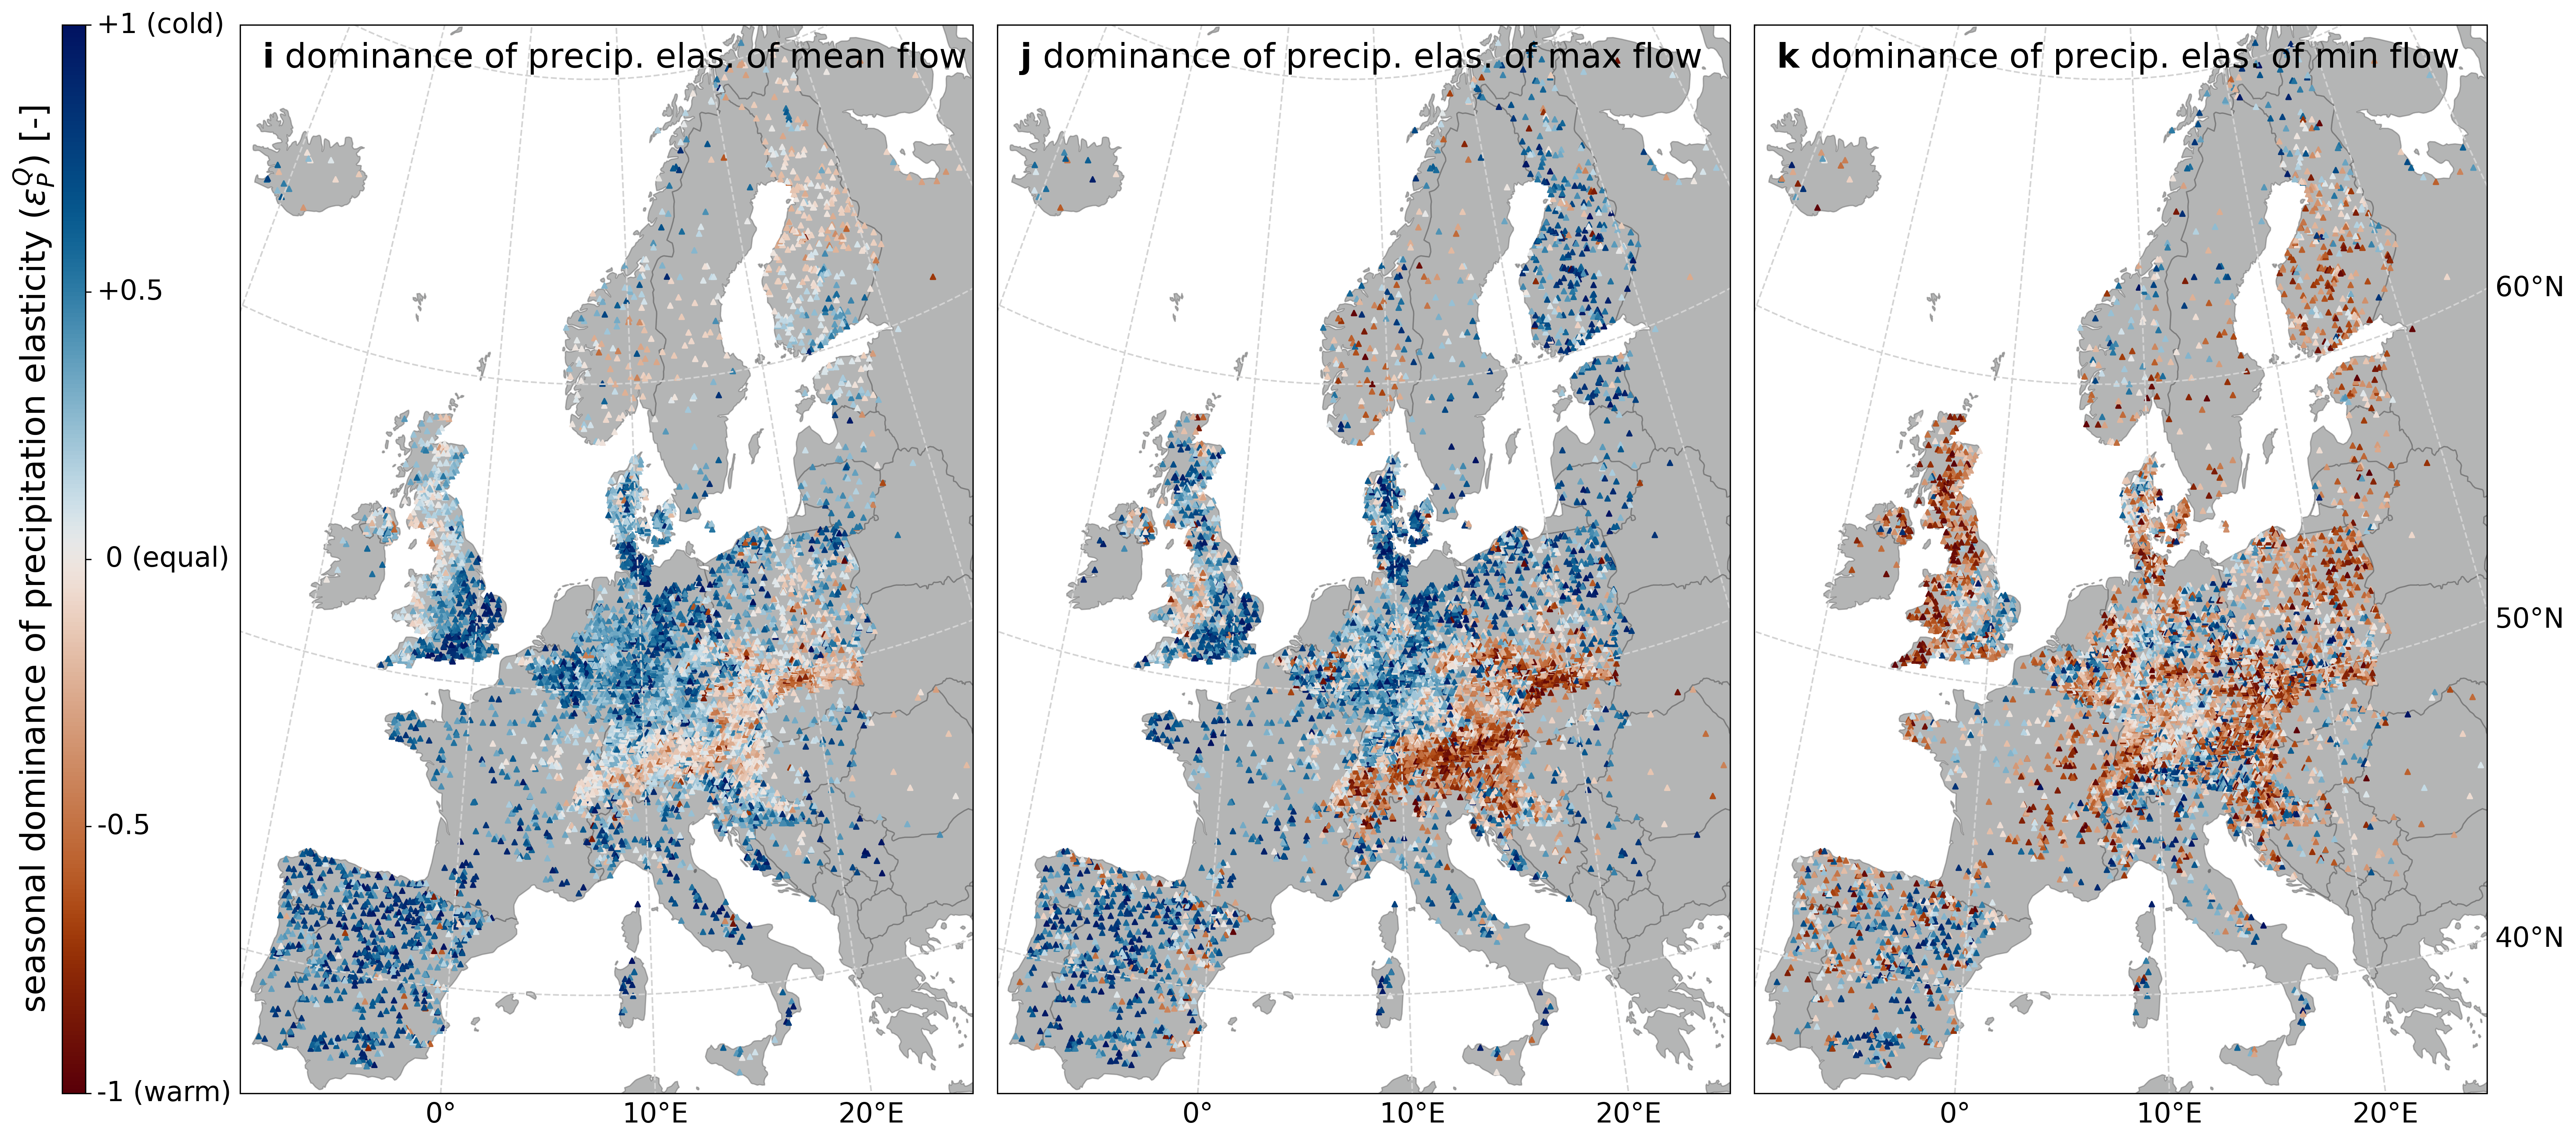

In [16]:
result_gdf_seasonal_ = result_gdf_mlr_seasonal.copy() #result_gdf_seasonal
print("Amount of catchments before excluding negative seasonal elasticities: ", len(result_gdf_seasonal_),".")

def plot_dominance_maps_with_colorbar(num_maps, cbar_title, titles, gdf, col_pref, cmap, vmin, vmax, v_ticks,fname):
    """
    Plots three geographic scatter plots for the seasonal dominance and saves them into a png.
    
    Parameters:
    - num_maps (int): Number of mapgs e.g. 3 or 4.
    - cbar_title (str): Title or the colourbar. 
    - titles (list): List of titles of the individual plots. 
    - gdf(geopandas.GeoDataFrame): GeoDataFrame containing the seasonal elasticities and dominance.
    - col_pref(str): Prefix for the column (not used).
    - cmap (matplotlib.colors.Colormap): Colormap to use for the plot, e.g. cm.vik_r.
    - vmin (float): Minimum value for the cbar.
    - vmax (float): Maximum value for the cbar.
    - v_ticks (float): Distance of vertical ticks, e.g. 0.2.
    - fname (str): File name to store the plot
                       
    Returns:
    - None
    """
    
    ft = 17
    europe_extent = [-9.5, 25, 36.7, 71] #[-9.5, 27, 36.7, 71]
    prj_lambert = ccrs.LambertAzimuthalEqualArea(central_longitude=7, central_latitude=53) #(central_longitude=9, central_latitude=54) 
    gdf_proj = gdf.to_crs(prj_lambert)
    extent_crs = ccrs.PlateCarree()
    
    # Plot size per map
    map_w = 8.5
    map_h = 11.9 #map_w / aspect_ratio
    
    # Layout config
    cbar_w = 0.27 #4
    pad_w_ticks = 1.3
    pad_w = 0.5
    total_w = cbar_w + pad_w_ticks + num_maps * map_w + pad_w

    # GridSpec
    ws = [cbar_w, pad_w_ticks] + [map_w] * num_maps + [pad_w]
    gs = GridSpec(1, num_maps + 3, width_ratios=ws, wspace=0.05)
    total_w = sum(gs.get_width_ratios()) 
    
    #fig_w = map_w * num_ma / (3 / total_ratio)  # ensures each map is width `w
    fig = plt.figure(figsize=(total_w, map_h), dpi=300)
    fig.patch.set_alpha(0)

    # Colorbar
    cax = fig.add_subplot(gs[0])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cb.set_label(cbar_title, fontsize=ft+4)
    cb.ax.yaxis.set_label_position('left')
    cb.ax.tick_params(labelsize=ft)
    #cb.ax.set_yticks(np.arange(vmin, vmax+0.1, v_ticks))
    #cb.ax.set_yticks(np.arange(vmin, vmax+0.1, 0.1), minor=True)
    
    cb.ax.set_yticklabels(['-1 (warm)', '-0.5', ' 0 (equal)', '+0.5', '+1 (cold)'])
    cb.ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    #cb.ax.set_yticks([-1, -0.5, 0, 0.5, 1], minor=True)
    for label in cb.ax.get_yticklabels():
        #label.set_rotation(45)
        label.set_ha('left')        # Align label to the left
        label.set_va('center')      # Keep vertically centered
    
    ## Compute dominance
    gdf_ = gdf_proj.copy()
    
    Qmet_list = [('Qmean', 'Pmean'), ('Qmax', 'Pmean'), ('Qmin', 'Pmean'), ('Qmax', 'Pmax')]

    for i, ((Q_str, met_str), title) in enumerate(zip(Qmet_list[:num_maps], titles[:num_maps])):
        ax = fig.add_subplot(gs[i+2], projection=prj_lambert) #ccrs.Mercator())
        ax.set_extent(europe_extent, crs=ccrs.PlateCarree()) #the projection the data is in
        ax.set_aspect('auto')
        ax.set_facecolor('white')
        
        # Masking out all negative values
        mask = (gdf_[str(Q_str+met_str+'Tmean_hfs-P_elas')] > -0.5) & (gdf_[str(Q_str+met_str+'Tmean_lfs-P_elas')] > -0.5)
        gdf_.loc[mask, str(Q_str+met_str+'_dominance')] = (((abs(gdf_.loc[mask, str(Q_str+met_str+'Tmean_hfs-P_elas')]) / 
                                                             (abs(gdf_.loc[mask, str(Q_str+met_str+'Tmean_hfs-P_elas')]) + abs(gdf_.loc[mask, str(Q_str+met_str+'Tmean_lfs-P_elas')]))) - 0.5) * 2).round(4)
        # filtereing out nans values (that either had negative hfs or lfs elasticities)
        gdf_filtered = gdf_[gdf_[str(Q_str+met_str+'_dominance')].notna()]
        
        hfs_lfs_nans = nan_count = gdf_[[str(Q_str+met_str+'Tmean_hfs-P_elas'), str(Q_str+met_str+'Tmean_lfs-P_elas')]].isna().any(axis=1).sum()
        #gdf_[(gdf_[str(Q_str+met_str+'Tmean_hfs-P_elas')] == np.nan) | (gdf_[str(Q_str+met_str+'Tmean_lfs-P_elas')] == np.nan)]
        #lfs_nans = (gdf_[str(Q_str+met_str+'Tmean_lfs-P_elas')] == np.nan)
        
        print(Q_str, met_str, " Amount of NaNs in either of the seasons before filtering: ", hfs_lfs_nans)
        print(rf"Amount of catchments filtered out (incl. nans): {len(gdf_)-len(gdf_filtered)} = {len(gdf_filtered)/len(gdf_):.3f}")
        
        colors = gdf_filtered[str(Q_str+met_str+'_dominance')].map(lambda x: cmap(norm(x))) #drop the nans
        
        gdf_filtered.plot(
            column=str(Q_str+met_str+'_dominance'), #label='significant',
            ax=ax, markersize=9, marker='^',cmap=cmap, edgecolor=colors,
            #transform=ccrs.PlateCarree(),
            vmin=vmin, vmax=vmax,alpha=1, zorder=2)

        europe.boundary.plot(ax=ax, transform=extent_crs, 
                             edgecolor='dimgrey',
                             facecolor='#6B6C6D',  #'#DCDCDC', 'whitesmoke', 'darkgray'
                             alpha=0.5, linewidth=0.8, zorder=1)
        
        # Gridlines
        gl = ax.gridlines(extent_crs,#crs=ccrs.PlateCarree(),
                          draw_labels=True, linewidth=1, color='lightgray', linestyle='--')
        # Set major gridlines at 10-degree intervals for both longitude and latitude
        gl.xlocator = ticker.MultipleLocator(10)  # Longitude gridlines every 10 degrees
        gl.ylocator = ticker.MultipleLocator(10)  # Latitude gridlines every 10 degrees

        gl.top_labels = gl.left_labels = False
        gl.bottom_labels = True
        if num_maps == 3:
            gl.right_labels = (i == 2)
        elif num_maps == 4:
            gl.right_labels = (i == 3)
        
        gl.xlabel_style = {'size': ft, 'color': 'k'}
        gl.ylabel_style = {'size': ft, 'color': 'k'}

        # Title
        ax.text(0.03, 0.985, title, transform=ax.transAxes,
                fontsize=ft+4, va='top', ha='left',
                bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        #ax.set_title(title, loc='left', fontsize=ft+4, pad=2)
        
    gdf1 = gdf_[['gauge_id', 'gauge_name', 'gauge_coun', #'gauge_prov', 
                 'river','lon_snap', 'lat_snap', 'lon', 'lat', 'geometry', 'wkt_geometry', 'QmeanPmean_dominance', 'QmaxPmean_dominance',
                 'QminPmean_dominance'#, 'QmaxPmax_dominance'
                ]]
    gdf1.to_csv(fp_processed/"03_sensitivities/02_seasonal/seasonal_dominance_summary.csv")

    plt.savefig(fp_figures/f"03_sensitivities/{fname}.png", dpi=300, bbox_inches='tight')
    plt.savefig(fp_figures/f"03_sensitivities/{fname}.pdf", bbox_inches='tight')
    plt.show()
    return
    

plot_dominance_maps_with_colorbar(num_maps=3,
                        cbar_title=rf'seasonal dominance of precipitation elasticity ($\epsilon^Q_P$) [-]',
                        titles = [rf'$\bf{{i}}$ dominance of precip. elas. of mean flow', 
                                    rf'$\bf{{j}}$ dominance of precip. elas. of max flow',
                                    rf'$\bf{{k}}$ dominance of precip. elas. of min flow',
                                    rf'$\bf{{l}}$ dominance of precip. elas. of max flow'],
                        gdf=result_gdf_seasonal_, col_pref=str(), #'_Tmean' or '_Tmean_hfs'
                        cmap=cm.vik_r,
                        vmin=-1, vmax=1, v_ticks=0.2,
                        fname=f"02_seasonal/maps/seasonal-NovApr-MarOct_QxPmean_elas_dominance-map_mlr",)